# Apêndice B

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"

## IMPORTAR BIBLIOTECAS

In [31]:
from enum import Enum
import numpy as np
import matplotlib.pyplot as plt
import os
import uuid
import cv2
import sys
import PIL
import PIL.Image
import xml.etree.ElementTree as ET
import datetime
import tensorflow as tf
from tensorboard.plugins.hparams import api as hp
from tensorflow import keras

gpu = tf.test.gpu_device_name()
if gpu == '':
    os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

## TREINAR/CARREGAR

In [3]:
flag = 1 #treinar modelo
flag = 0 #carregar modelo !! (Comente para treinar e salvar)

## CONFIGURAÇÕES.

In [4]:
input_shape = (160,160,3)
batch = 32

### Importar dataset.

In [5]:
BASE_PATH = ['../..','datasets']
DATASETS_DIR=['PKLot','UFPR04','UFPR05','PUCPR']

class DATASETS(Enum):
    UFPR04 = os.path.join(BASE_PATH[0],BASE_PATH[1],DATASETS_DIR[0],DATASETS_DIR[1])
    UFPR05 = os.path.join(BASE_PATH[0],BASE_PATH[1],DATASETS_DIR[0],DATASETS_DIR[2])
    PUCPR  = os.path.join(BASE_PATH[0],BASE_PATH[1],DATASETS_DIR[0],DATASETS_DIR[3])    

In [6]:
DATASET_DIR = DATASETS.UFPR05.value

if DATASET_DIR == DATASETS.UFPR04.value:
    vagas  = 28
    pontos = vagas*4
    nVagas = 28
    nVagas = vagas - nVagas


if DATASET_DIR == DATASETS.UFPR05.value:
    vagas  = 40
    pontos = vagas*4
    pontos = vagas*4
    nVagas = 37
    nVagas = vagas - nVagas

if DATASET_DIR == DATASETS.PUCPR.value:
    vagas  = 100
    pontos = vagas*4
    nVagas = 100
    nVagas = vagas - nVagas

### Configurar dataset

In [7]:
IMAGE_DIR = os.path.join(DATASET_DIR,'todas')
XML_DIR = IMAGE_DIR


IMAGE_LIST = []
XML_LIST = []
def criarLista():
    for file in os.listdir(IMAGE_DIR):
        if file.endswith(".jpg"):

            file = os.path.join(IMAGE_DIR,file)
            IMAGE_LIST.append(file)
    IMAGE_LIST.sort()

    for file in os.listdir(IMAGE_DIR):
        if file.endswith(".xml"):

            file = os.path.join(XML_DIR,file)
            XML_LIST.append(file)
    XML_LIST.sort()


criarLista()
#debug
print(IMAGE_DIR)
print(XML_DIR)
print(IMAGE_LIST[:2])
print(XML_LIST[:2])

../../datasets/PKLot/UFPR05/todas
../../datasets/PKLot/UFPR05/todas
['../../datasets/PKLot/UFPR05/todas/2013-02-22_06_05_00.jpg', '../../datasets/PKLot/UFPR05/todas/2013-02-22_06_10_00.jpg']
['../../datasets/PKLot/UFPR05/todas/2013-02-22_06_05_00.xml', '../../datasets/PKLot/UFPR05/todas/2013-02-22_06_10_00.xml']


## CARREGAR ENTRADAS E SPLIT DA BASE.

In [8]:
DADOS_DIR = os.path.join(DATASET_DIR,'output')
X = tf.keras.preprocessing.image_dataset_from_directory(DADOS_DIR, image_size=input_shape[:2], batch_size=batch, label_mode='binary',
                                                        shuffle=True, seed=123, color_mode='rgb', validation_split=0.7, subset = 'training')


X_val = tf.keras.preprocessing.image_dataset_from_directory(DADOS_DIR, image_size=input_shape[:2], batch_size=batch, label_mode='binary',
                                                        shuffle=True, seed=123, color_mode='rgb', validation_split=0.7, subset = 'validation')

class_names = X.class_names
print('\nClasses: {} em {}'.format(X.class_names,DADOS_DIR))

Found 27680 files belonging to 2 classes.
Using 8304 files for training.
Found 27680 files belonging to 2 classes.
Using 19376 files for validation.

Classes: ['livre', 'ocupada'] em ../../datasets/PKLot/UFPR05/output


### Split - devel e teste

In [9]:
val_batches = tf.data.experimental.cardinality(X_val)
X_test = X_val.take(val_batches // 5)
X_val  = X_val.skip(val_batches // 5)

print('Lotes de validação: %d' % tf.data.experimental.cardinality(X_val))
print('Lotes de Teste: %d' % tf.data.experimental.cardinality(X_test))

Lotes de validação: 485
Lotes de Teste: 121


### Otimização do pipeline

In [10]:
AUTOTUNE = tf.data.AUTOTUNE

X = X.prefetch(buffer_size=AUTOTUNE)
X_val = X_val.prefetch(buffer_size=AUTOTUNE)
X_test = X_test.prefetch(buffer_size=AUTOTUNE)

### Testando o supervisor.

2021-10-12 22:30:39.407449: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


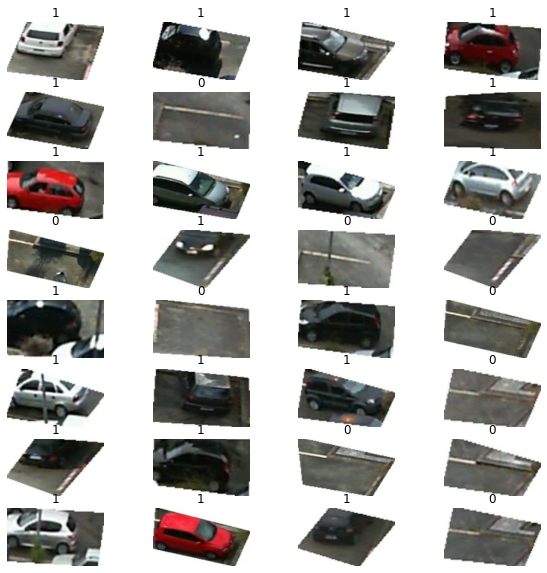

In [11]:
plt.figure(figsize=(10, 10))
for images, labels in X_test.take(1):
    for i in range(32):
        ax = plt.subplot(8, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"),aspect=0.6, extent=[0,100,0,100])
        plt.title(int(labels[i]))
        plt.axis("off")

## EXEMPLO DE IMAGEM NÃO SEGMENTADA.

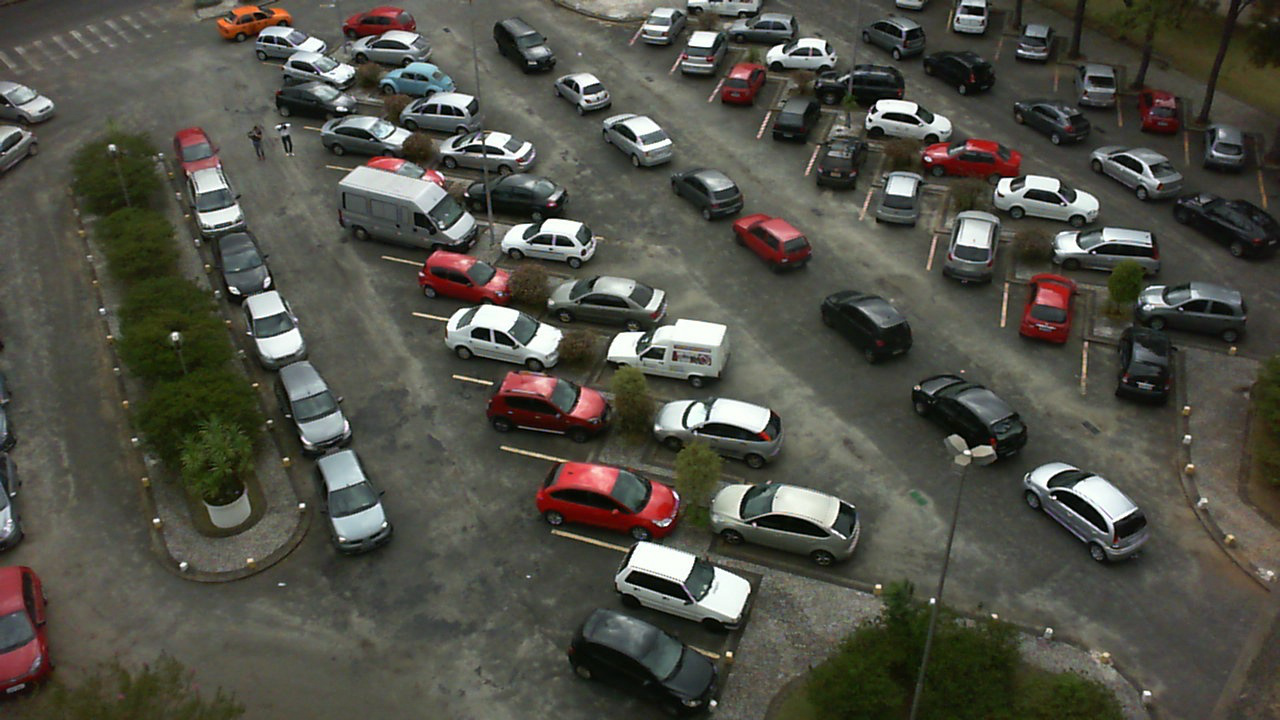

In [12]:
sort = np.random.randint(len(IMAGE_LIST))

PIL.Image.open(IMAGE_LIST[sort])

## TRANSFER LEARNING

### Normalizar as imagens para o padrão do modelo da mobilenet_v2

In [13]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)

### Criar o modelo base.

In [14]:
base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape,
                                               include_top=False,
                                               weights='imagenet')

base_model.trainable = False
#base_model.summary()

## MODELO.

In [15]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)(inputs)
x = base_model(x, training=False) # O modelo contem uma camada de Normalização. Não destruir os pesos aprendidos
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.3)(x)
outputs = tf.keras.layers.Dense(1)(x)

model = tf.keras.Model(inputs, outputs)

base_learning_rate = 0.0001

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
rescaling_1 (Rescaling)      (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_______________________________________________

### Configurando o tensorboard

In [16]:
LOG_DIR = os.path.join(DATASET_DIR,'model','logs','fit')
LOG_DIR2 = os.path.join(LOG_DIR,datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=LOG_DIR2, histogram_freq=1)

2021-10-12 22:30:42.021051: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-12 22:30:42.021076: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-12 22:30:42.023196: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


### Configurando callback de checkpoint

In [17]:
CHECKPOINT_DIR = os.path.join(DATASET_DIR,'model')
CHECKPOINT_PATH = CHECKPOINT_DIR+os.sep+'checkpoint' 

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=CHECKPOINT_PATH,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    verbose=1,
    save_best_only=True)

### Treinar/Carregar.

In [18]:
if flag:
    
    history = model.fit(X, epochs=5, validation_data=X_val,callbacks=[tensorboard_callback, checkpoint_callback])
    
    
else:
    
    LOAD_DIR = os.path.join(DATASET_DIR,'model')

    model = keras.models.load_model(LOAD_DIR)
    #model.load_weights(CHECKPOINT_PATH)    

### Métricas

In [19]:
if flag:
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()),1])
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.ylim([0,0.1])
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

    %load_ext tensorboard
    file_writer = tf.summary.create_file_writer(LOG_DIR2)
    %tensorboard --logdir {LOG_DIR}

### Salvar modelo

In [20]:
if flag:
    SAVE_DIR = os.path.split(DATASET_DIR)[0] # Separa (head,tail) -> Indice [0] = head
    SAVE_DIR = os.path.join(DATASET_DIR,'model')
    model.save(
        SAVE_DIR,
        overwrite=False,
        include_optimizer=True,
        save_format=None,
        signatures=None,
        options=None,
        save_traces=True,
    )

### Validar modelo na base de teste

In [21]:
model.load_weights(CHECKPOINT_PATH) 
score = model.evaluate(X_test, verbose=2)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

121/121 - 22s - loss: 0.0285 - accuracy: 0.9920
Test loss: 0.02852698042988777
Test accuracy: 0.99199378490448


### Predição em lote de teste

Predição = 0, [0.0] = Label
Predição = 0, [0.0] = Label
Predição = 1, [1.0] = Label
Predição = 1, [1.0] = Label
Predição = 1, [1.0] = Label
Predição = 1, [1.0] = Label
Predição = 0, [0.0] = Label
Predição = 0, [0.0] = Label
Predição = 1, [1.0] = Label
Predição = 0, [0.0] = Label
Predição = 0, [0.0] = Label
Predição = 1, [1.0] = Label
Predição = 1, [1.0] = Label
Predição = 1, [1.0] = Label
Predição = 0, [0.0] = Label
Predição = 1, [1.0] = Label
Predição = 0, [0.0] = Label
Predição = 1, [1.0] = Label
Predição = 0, [0.0] = Label
Predição = 1, [1.0] = Label
Predição = 1, [1.0] = Label
Predição = 0, [0.0] = Label
Predição = 0, [0.0] = Label
Predição = 0, [0.0] = Label
Predição = 1, [1.0] = Label
Predição = 0, [0.0] = Label
Predição = 0, [0.0] = Label
Predição = 0, [0.0] = Label
Predição = 1, [1.0] = Label
Predição = 0, [0.0] = Label
Predição = 1, [1.0] = Label
Predição = 0, [0.0] = Label


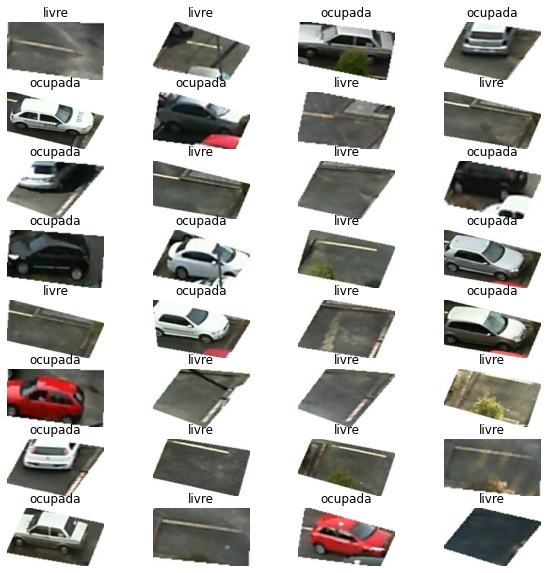

In [22]:
image_batch, label_batch = X_test.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

for i in range (len(predictions)):
    print('Predição = {}, {} = Label'.format(predictions[i].numpy(),label_batch[i].tolist()))

plt.figure(figsize=(10, 10))
for i in range(32):
  ax = plt.subplot(8, 4, i + 1)
  plt.imshow(image_batch[i].astype("uint8"),aspect=0.6, extent=[0,100,0,100])
  plt.title(class_names[predictions[i]])
  plt.axis("off")

## PREDIÇÃO EM TEMPO REAL

### Carregar XML e criar os pontos das ROI's.

In [23]:
tree = ET.parse(XML_LIST[0])
root = tree.getroot()

pts = np.empty(0,np.int32)
vaga = np.empty(0,np.int32)

for neighbor in root.iter('point'):
    x,y = neighbor.attrib.values()
    x = int(x)
    y = int(y)
    a = [x,y]
    pts = np.append(pts,[x,y])
    
for neighbor in root.iter('space'):
    if(len(neighbor.attrib.values())==2):
        _,occupied = neighbor.attrib.values()
        occupied = int(occupied)
    if(len(neighbor.attrib.values())==1):
        occupied=0
        
    vaga = np.append(vaga,occupied)

#debug
print(pts[0:4])
print(vaga[0:vagas])

paresXY = np.array(np.zeros((pontos,2)),np.int32) 
j=0
for i in range(pontos):
    paresXY[i] = pts[j:j+2]
    j = j+2

#debug
paresXY[0:4]

[608 613 741 654]
[0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]


array([[608, 613],
       [741, 654],
       [775, 582],
       [608, 526]], dtype=int32)

### Função de segmentação

In [24]:
def crop(j=0,i=0):
    rect = cv2.boundingRect(paresXY[j:j+4])
    x,y,w,h = rect
    croped = im[y:y+h, x:x+w].copy()

    pts = paresXY[j:j+4] - paresXY[j:j+4].min(axis=0)
    mask = np.zeros(croped.shape[:2], croped.dtype)
    cv2.drawContours(mask, [pts], -1, (255, 255, 255), -1, cv2.LINE_AA)

    ## (3) do bit-op
    dst = cv2.bitwise_and(croped, croped, mask=mask) #background preto

    bg = np.ones_like(croped, np.uint8)*255
    cv2.bitwise_not(bg,bg, mask=mask)
    dst2 = bg+ dst #background branco
    
    image = cv2.resize(dst2, input_shape[:2], interpolation = cv2.INTER_CUBIC)
    
    img = image.copy()
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array,  0)

    predictions = model.predict(img_array)
     
    score = predictions[0]
    score = float(score)
    return score
    

### Função para combinar a imagem sem predição e imagem com predição em uma única janela

In [25]:
def juntar(im2,im,scale=80):
    
    img = np.hstack((im2, im))
    
    scale_percent = scale 
    width = int(img.shape[1] * scale_percent / 100)
    height = int(img.shape[0] * scale_percent / 100)
    dim = (width, height)
    resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)  
    return resized

### Carregar e preditar várias imagens aleatórias

In [47]:
for i in range (20): #definir o número de imagens que será chamado.
    
    sort = np.random.randint(len(IMAGE_LIST))
    im = cv2.imread(IMAGE_LIST[sort])
    im2 = im.copy()
    if im is None:
        sys.exit("A imagem não foi carregada.")

    j=0
    contador = 0
    for i in range(nVagas,len(paresXY)//4):

        score = crop(j,i)
        #print(score)
        if((score)<0):
            cv2.polylines(im,[paresXY[j:j+4]],True,(0,255,255),2)
            contador = contador +1
            #print(score)
        j=j+4
        
        

    cv2.putText(im,str(contador),(10,700), cv2.FONT_HERSHEY_SIMPLEX, 4,(255,255,255),5,cv2.LINE_AA)
    img_junta = juntar(im2,im,70)
    arquivo = 'predicao'+str(uuid.uuid1())+'.png'
    cv2.imwrite(arquivo,im)
    cv2.imshow(IMAGE_LIST[sort], im)
    k = cv2.waitKey(0)
    cv2.destroyAllWindows()

### Carregar Video.

In [40]:
VIDEO_FILE = os.path.join(DATASET_DIR,'pklot.mp4')
cap = cv2.VideoCapture(VIDEO_FILE)

if cap.isOpened() == False:
    print('Video não encontrado.')

while(cap.isOpened()):
    ret, im = cap.read()
    height, width, _ = im.shape
    
    if ret == True:
    
        j=0
        contador = 0
                
    
        for i in range(nVagas,len(paresXY)//4):
            
            score = crop(j,i)
            if((score)<0.7):
                cv2.polylines(im,[paresXY[j:j+4]],True,(0,255,255),2)
                contador = contador +1
            j=j+4
        
        cv2.putText(im,str(contador),(10,700), cv2.FONT_HERSHEY_SIMPLEX, 4,(255,255,255),5,cv2.LINE_AA)
        cv2.imshow('Estacionamento', im)
        
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    
    else:
        break
cap.release()
cv2.destroyAllWindows()

In [45]:
'predicao'+str(uuid.uuid1())+'.png'

'predicao306aabba-2bc7-11ec-a24b-5f6b4aa81d5a.png'

## Debug 

(-0.5, 1279.5, 719.5, -0.5)

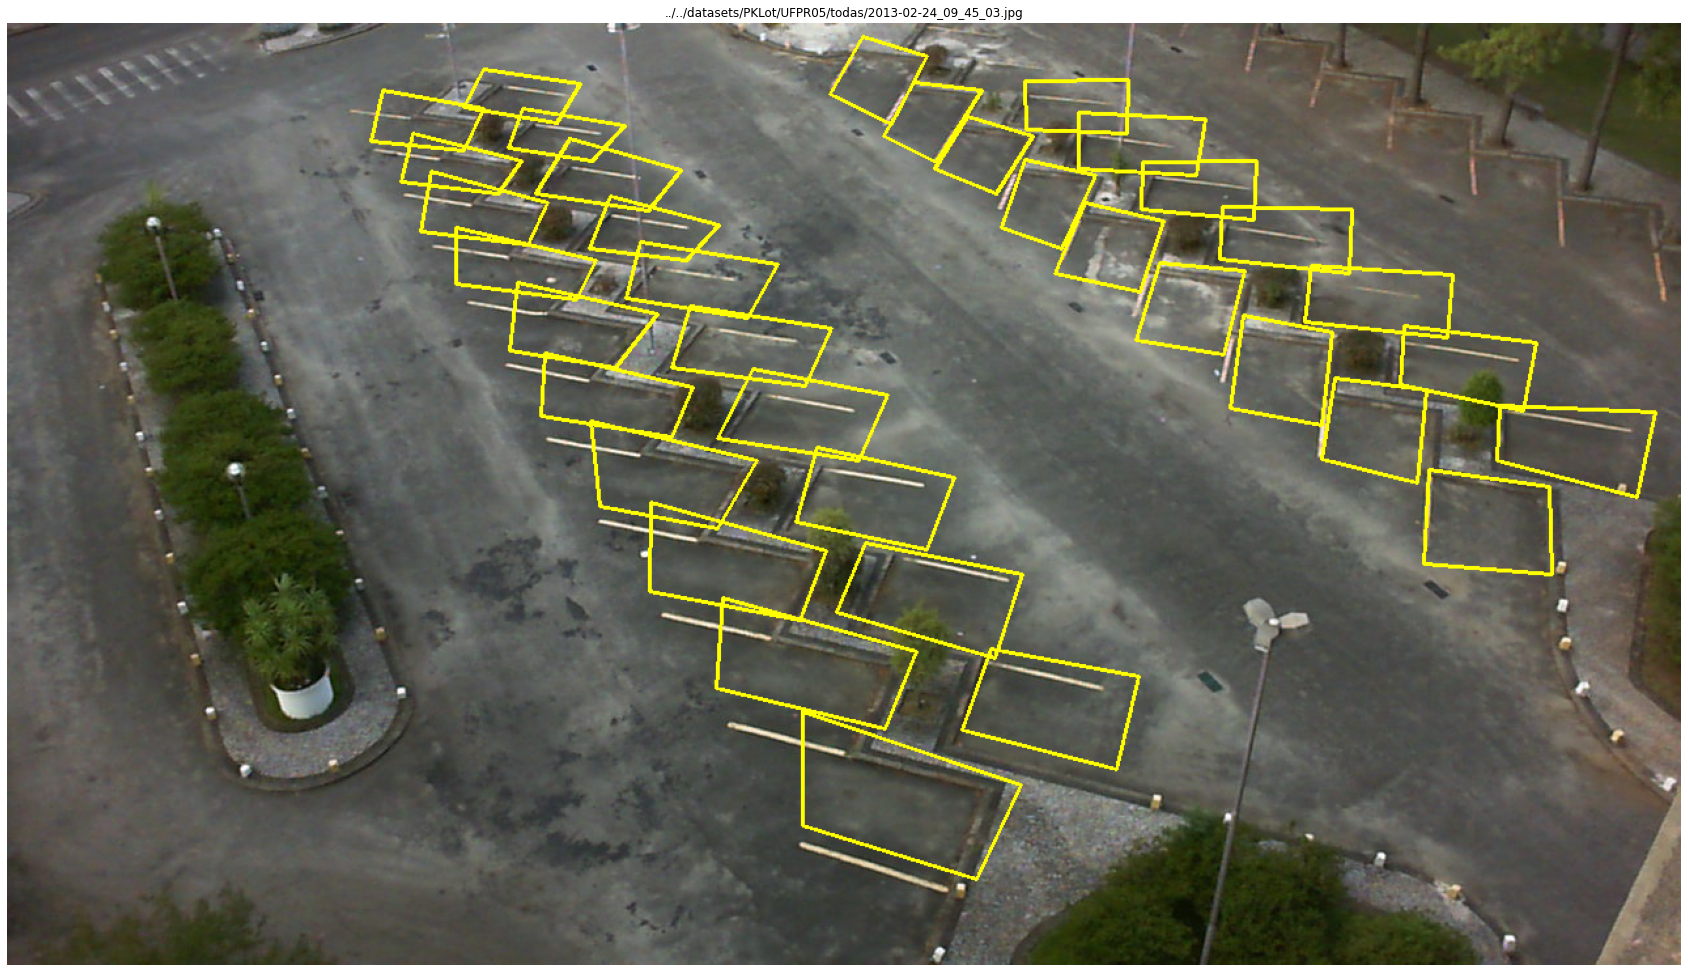

In [28]:
im = plt.imread(IMAGE_LIST[450])
j=0
contador = 0
for i in range(nVagas,len(paresXY)//4):

    score = crop(j,i)
    #print(score)
    if((score)<0.0):
        cv2.polylines(im,[paresXY[j:j+4]],True,(255,255,0),2)
        contador = contador +1
        #print(score)
    j=j+4

fig = plt.figure(figsize=(30, 30))
plt.imshow(im)
plt.title(IMAGE_LIST[350])
plt.axis("off")